In [284]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import cholesky

np.random.seed(123456)

In [533]:
class UKF():  
    # Goal: Estimate state vector x, v, a in one physical dimension
    def __init__(self): 
        self.dt = 0.1
        self.total_duration = 16
        self.time = np.arange(0, self.total_duration + self.dt, self.dt)
        self.lamb = 3
        
        self.state_len = 3
        self.mu_ukf = np.zeros((3, len(self.time)))
        self.mu_ukf[:, 0] = [1, 1, 1]    # initialize initial state 
        self.cov_ukf = [np.eye(3) for j in range(len(self.time))]
        
        self.ground_truth = np.zeros((3, len(self.time)))
        self.ground_truth[:, 0] = [1, 1, 1]
        
        self.Q = 0.1 * np.eye(3)
        self.R = 0.1 * np.eye(3)
        
    
    # Dynamics for time slices first fourth and third fourth 
    def nonlinear_fluc_dynamics_a(self, state_control): 
        x_t = state_control[0]
        v_t = state_control[1]
        a_t = state_control[2]
        D_a = np.array([np.sin(x_t) + (v_t * np.cos(a_t) * self.dt), 
                        np.cos(x_t) + (np.sin(v_t) * self.dt), 
                        x_t + (np.cos(v_t) * self.dt)])
        return D_a
    
    # Dynamics for time slices second fourth and last fourth 
    def nonlinear_fluc_dynamics_b(self, state_control): 
        x_t = state_control[0]
        v_t = state_control[1]
        a_t = state_control[2]
        D_b = np.array([np.cos(x_t) + (a_t * np.cos(v_t) * self.dt), 
                        np.sin(x_t) + (np.sin(v_t) * self.dt), 
                        np.sin(a_t) + (v_t * self.dt)])
        return D_b
    
    def measurement_model(self, state_control):
        x_p = state_control[0]
        v_p = state_control[1]
        a_p = state_control[2]
        return np.array([np.sin(x_p) * (np.cos(v_p) + np.sin(a_p)), 0, 0])
    
    def ukf_transf(self, mu, cov, weights, nonlinear_model): 
        n = len(mu)   # dimension of state space 
        matrix_cholesky = (n + self.lamb) * cov
        matrix_cholesky += np.eye(matrix_cholesky.shape[0])
        perturb_matrix = cholesky(matrix_cholesky, lower=True).T
        S = [mu]
        for i in range(n):   # create sigma points  
            S.append(mu + perturb_matrix[i])
            S.append(mu - perturb_matrix[i])
        updated_S = [nonlinear_model(s) for s in S]
        updated_mu = sum(w * s for w, s in zip(weights, updated_S))
        updated_cov = sum(w * np.outer(s - updated_mu, s - updated_mu) for w, s in zip(weights, updated_S))        
        return updated_mu, updated_cov, S, updated_S
    
    def ukf_execute(self): 
        weights = [self.lamb / (self.state_len + self.lamb)] + [1 / (2 * (self.state_len + self.lamb))] * (2 * self.state_len)
        n = len(self.time)
        for i in range(1, n):
            dyn_noise = np.random.multivariate_normal(np.zeros((3,)), self.Q)
            obs_noise = np.random.multivariate_normal(np.zeros((3,)), self.R)
                        
            mu_p = cov_p = S_p = updated_S_p = None
            
            # Predict Step
            if i <= n // 4 or (i >= n // 2 and i <= ((3 * n) // 4)):
                mu_p, cov_p, S_p, updated_S_p = self.ukf_transf(self.mu_ukf[:, i-1], self.cov_ukf[i-1], weights, self.nonlinear_fluc_dynamics_a)
                self.ground_truth[:, i] = self.nonlinear_fluc_dynamics_a(self.ground_truth[:, i-1]) + dyn_noise
 
            else: 
                mu_p, cov_p, S_p, updated_S_p = self.ukf_transf(self.mu_ukf[:, i-1], self.cov_ukf[i-1], weights, self.nonlinear_fluc_dynamics_b)
                self.ground_truth[:, i] = self.nonlinear_fluc_dynamics_b(self.ground_truth[:, i-1]) + dyn_noise
                        
            # Update Step 
            o = self.measurement_model(self.ground_truth[:, i]) + obs_noise
            mu_o, cov_o, S_o, updated_S_o = self.ukf_transf(mu_p, cov_p, weights, self.measurement_model)         
            mu_o += obs_noise
            cross_cov = sum(w * np.outer(s - mu_p, updated_s - mu_o) for w, s, updated_s in zip(weights, S_o, updated_S_o))
            cov_o = cov_o + 1e-6 * np.eye(cov_o.shape[0])
            K = cross_cov @ np.linalg.inv(cov_o)
            self.mu_ukf[:, i] = mu_p + K @ (o - mu_o) + dyn_noise
            self.cov_ukf[i] = cov_p - K @ cov_o @ K.T

In [534]:
ukf = UKF()
ukf.ukf_execute()

In [535]:
rmse_pose = np.sqrt(np.mean((ukf.mu_ukf[0] - ukf.ground_truth[0]) ** 2))
mae_pose = np.mean(np.abs(ukf.mu_ukf[0] - ukf.ground_truth[0]))

rmse_vel = np.sqrt(np.mean((ukf.mu_ukf[1] - ukf.ground_truth[1]) ** 2))
mae_vel = np.mean(np.abs(ukf.mu_ukf[1] - ukf.ground_truth[1]))

rmse_accel = np.sqrt(np.mean((ukf.mu_ukf[2] - ukf.ground_truth[2]) ** 2))
mae_accel = np.mean(np.abs(ukf.mu_ukf[2] - ukf.ground_truth[2]))

print(f'RMSE for UAV Pose: {rmse_pose}')
print(f'RMSE for UAV Velocity: {rmse_vel}')
print(f'RMSE for UAV Acceleration: {rmse_accel}\n')

print(f'MAE for UAV Pose: {mae_pose}')
print(f'MAE for UAV Velocity: {mae_vel}')
print(f'MAE for UAV Acceleration: {mae_accel}')

RMSE for UAV Pose: 0.29412758225625885
RMSE for UAV Velocity: 0.23565773131416062
RMSE for UAV Acceleration: 0.3145501400288475

MAE for UAV Pose: 0.21969542184060897
MAE for UAV Velocity: 0.16831373070809136
MAE for UAV Acceleration: 0.23822859748584913


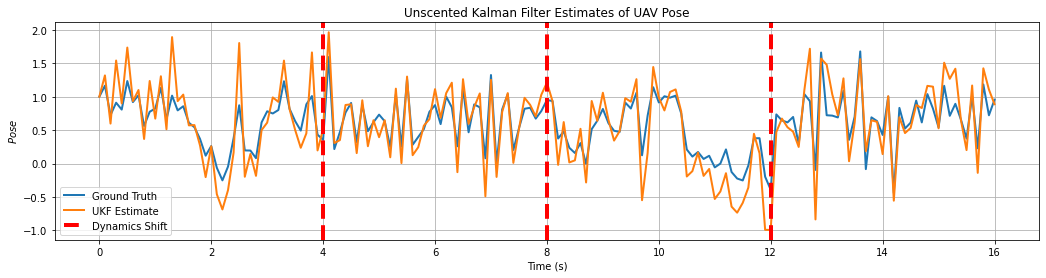

In [540]:
plt.figure(figsize=(60, 4))

plt.subplot(131)
plt.title('Unscented Kalman Filter Estimates of UAV Pose')
plt.plot(ukf.time, ukf.ground_truth[0, :], linewidth=2, label='Ground Truth')
plt.plot(ukf.time, ukf.mu_ukf[0, :], linewidth=2, label='UKF Estimate')

plt.axvline(x=4, color='red', linestyle='--', linewidth=4, label='Dynamics Shift')
plt.axvline(x=8, color='red', linestyle='--', linewidth=4)
plt.axvline(x=12, color='red', linestyle='--', linewidth=4)

plt.xlabel('Time (s)')
plt.ylabel(r'$Pose$')
plt.legend()
plt.grid(True)

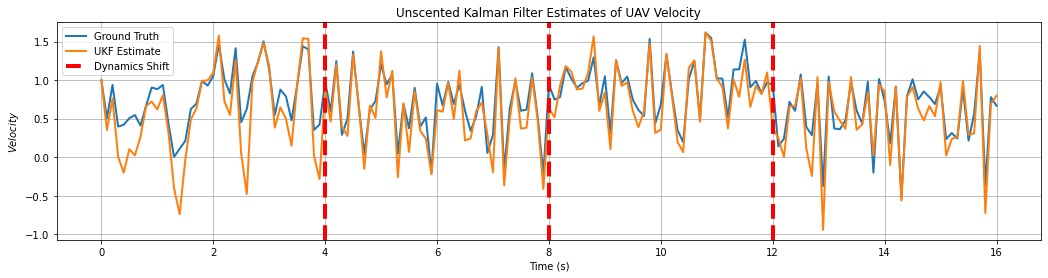

In [541]:
plt.figure(figsize=(60, 4))

plt.subplot(131)
plt.title('Unscented Kalman Filter Estimates of UAV Velocity')
plt.plot(ukf.time, ukf.ground_truth[1, :], linewidth=2, label='Ground Truth')
plt.plot(ukf.time, ukf.mu_ukf[1, :], linewidth=2, label='UKF Estimate')

plt.axvline(x=4, color='red', linestyle='--', linewidth=4, label='Dynamics Shift')
plt.axvline(x=8, color='red', linestyle='--', linewidth=4)
plt.axvline(x=12, color='red', linestyle='--', linewidth=4)

plt.xlabel('Time (s)')
plt.ylabel(r'$Velocity$')
plt.legend()
plt.grid(True)

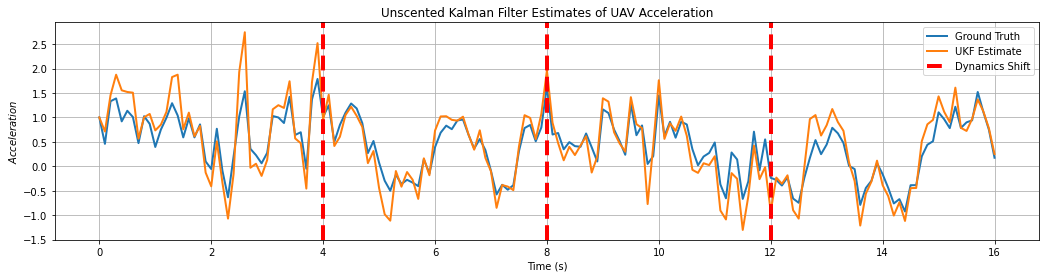

In [542]:
plt.figure(figsize=(60, 4))

plt.subplot(131)
plt.title('Unscented Kalman Filter Estimates of UAV Acceleration')
plt.plot(ukf.time, ukf.ground_truth[2, :], linewidth=2, label='Ground Truth')
plt.plot(ukf.time, ukf.mu_ukf[2, :], linewidth=2, label='UKF Estimate')

plt.axvline(x=4, color='red', linestyle='--', linewidth=4, label='Dynamics Shift')
plt.axvline(x=8, color='red', linestyle='--', linewidth=4)
plt.axvline(x=12, color='red', linestyle='--', linewidth=4)

plt.xlabel('Time (s)')
plt.ylabel(r'$Acceleration$')
plt.legend()
plt.grid(True)